# Week 4
# Mining Association Rules

In this project, we will analyze [a data set about online browsing behavior](http://snap.stanford.edu/class/cs246-data/browsing.txt), and identify significant association rules among the items. Each line represents a browsing session of a customer, and each item is represented by a string of 8 characters.

We will implement the A Priori algorithm with PySpark. The goal is to find significant association rules with $s\ge 100$ and high confidence scores.

In [1]:
# Install Spark
# https://github.com/twistedmove/CS246/blob/master/hw1/hw1.pdf
# https://github.com/wrwwctb/Stanford-CS246-2018-2019-winter/blob/master/completed/1_2_de.py
# https://github.com/twistedmove/CS246/blob/master/hw1/hw1q2/h1q2.py
!pip install pyspark
# !pip install -U -q PyDrive
# !apt install openjdk-8-jdk-headless -qq
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=4dbcf8dcf8d33b63fd2e5c3ebd72b849edbaddb05f601df0b7e767c469c83a06
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
# Download the browsing data
!wget http://snap.stanford.edu/class/cs246-data/browsing.txt

--2024-09-12 00:06:19--  http://snap.stanford.edu/class/cs246-data/browsing.txt
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3458517 (3.3M) [text/plain]
Saving to: ‘browsing.txt’

browsing.txt        100%[===================>]   3.30M   970KB/s    in 6.5s    

2024-09-12 00:06:26 (518 KB/s) - ‘browsing.txt’ saved [3458517/3458517]



In [3]:
import pandas as pd
df=pd.read_csv('browsing.txt',header=None,names=["browsing_session"],)#,delimiter=" "
df.head()

,browsing_session
0,FRO11987 ELE17451 ELE89019 SNA90258 GRO99222
1,GRO99222 GRO12298 FRO12685 ELE91550 SNA11465 E...
2,ELE17451 GRO73461 DAI22896 SNA99873 FRO86643
3,ELE17451 ELE37798 FRO86643 GRO56989 ELE23393 S...
4,ELE17451 SNA69641 FRO86643 FRO78087 SNA11465 G...


In [4]:
# Create a Spark context
import re, sys, operator
import pyspark

In [5]:
# Load the data file as an RDD object
sc = pyspark.SparkContext()
lines = sc.textFile('browsing.txt')
baskets = lines.map(lambda l: l.split())
N = baskets.count()
print("N:", N)

N: 31101


## Resilient Distributed Datasets
Resilient Distributed Datasets (RDDs) are the basic building block of Spark for distributed computation. Note that RDD objects are immutable and are computed lazily.

## RDD I/O
- `textFile()`: load data from a text file.
- `take(n)`: return the first $n$ elements as an array
- `collect()`: return all elements. **Use with caution**.
- `count()`: return the number of elements.
- `saveAsTextFile()`

## RDD Operations
Every RDD operation returns a new RDD.
- `map()`: apply an operation to every element of an RDD
- `flatMap()`: apply an operation to every element, and return a list of all results combined.
- `mapValues()`: apply an operation to the value of every tuple in a paired RDD.
- `flatMapValues()`
- `filter()`: apply an operation and filter the elements.
- `groupByKey()`
- `sortBy()`
- `sortByKey()`
- `join()`
- `reduce()`: combine the elements using an associative function.
- `reduceByKey()`

**References:**
- [RDD Programming Guide](http://spark.apache.org/docs/latest/rdd-programming-guide.html)
- [A Video Introduction to RDD](https://www.youtube.com/watch?v=LKoGHTR-MgE&list=PLoCMsyE1cvdVnCgHk43vRy7PVTVWJ6WVR&index=23)


In [6]:
baskets = baskets.map(lambda b: sorted(set(b)))
baskets.take(5)

[['ELE17451', 'ELE89019', 'FRO11987', 'GRO99222', 'SNA90258'],
 ['ELE17451',
  'ELE26917',
  'ELE52966',
  'ELE91550',
  'FRO12685',
  'FRO84225',
  'FRO90334',
  'GRO12298',
  'GRO99222',
  'SNA11465',
  'SNA30755',
  'SNA80192'],
 ['DAI22896', 'ELE17451', 'FRO86643', 'GRO73461', 'SNA99873'],
 ['ELE17451', 'ELE23393', 'ELE37798', 'FRO86643', 'GRO56989', 'SNA11465'],
 ['DAI54444',
  'ELE11375',
  'ELE17451',
  'ELE28573',
  'FRO78087',
  'FRO86643',
  'GRO39357',
  'SNA11465',
  'SNA69641']]

In [7]:
def singles_helper(basket):
    ret = []
    for item in basket:
        ret.append((item, 1))
    return ret

In [14]:
singles_support = baskets.flatMap(singles_helper)
singles_support.take(10)

[('ELE17451', 1),
 ('ELE89019', 1),
 ('FRO11987', 1),
 ('GRO99222', 1),
 ('SNA90258', 1),
 ('ELE17451', 1),
 ('ELE26917', 1),
 ('ELE52966', 1),
 ('ELE91550', 1),
 ('FRO12685', 1)]

In [15]:
singles_support = singles_support.reduceByKey(lambda x, y: x + y)
singles_support.take(5)

[('FRO11987', 104),
 ('SNA90258', 550),
 ('ELE52966', 380),
 ('ELE91550', 23),
 ('FRO84225', 74)]

In [16]:
print(singles_support.count())
singles_support = singles_support.filter(lambda x: x[1] >= 100)
print(singles_support.count())

12592
647


In [17]:
singles = dict(singles_support.collect())
singles

{'FRO11987': 104,
 'SNA90258': 550,
 'ELE52966': 380,
 'SNA80192': 258,
 'DAI22896': 1219,
 'FRO86643': 235,
 'GRO73461': 3602,
 'ELE11375': 214,
 'GRO39357': 296,
 'SNA69641': 599,
 'DAI50921': 350,
 'DAI22177': 1627,
 'ELE59935': 1311,
 'SNA85662': 349,
 'SNA91554': 208,
 'DAI14125': 163,
 'DAI49199': 664,
 'ELE66810': 1697,
 'DAI87514': 254,
 'GRO12935': 169,
 'GRO36567': 832,
 'GRO48282': 184,
 'SNA55952': 1094,
 'DAI48891': 825,
 'ELE11111': 811,
 'FRO92261': 915,
 'SNA66979': 703,
 'DAI88808': 123,
 'FRO16142': 931,
 'FRO41069': 409,
 'DAI22534': 287,
 'FRO19520': 133,
 'FRO24098': 521,
 'FRO98878': 157,
 'DAI55911': 974,
 'FRO31317': 2330,
 'FRO38366': 353,
 'SNA59903': 891,
 'SNA72163': 1090,
 'ELE20196': 545,
 'ELE30182': 274,
 'FRO98184': 480,
 'DAI63921': 1773,
 'SNA18336': 709,
 'FRO62970': 115,
 'SNA83730': 379,
 'DAI91290': 1138,
 'DAI32480': 165,
 'SNA14713': 188,
 'SNA93641': 240,
 'GRO17442': 101,
 'SNA89670': 169,
 'SNA93730': 320,
 'DAI84001': 363,
 'ELE12792': 832,


In [18]:
{k: v for k, v in sorted(singles.items(), key=lambda item: item[1])}

{'DAI51778': 100,
 'SNA90993': 100,
 'ELE12808': 100,
 'GRO90585': 100,
 'ELE40371': 100,
 'GRO17442': 101,
 'SNA90161': 101,
 'ELE36588': 101,
 'ELE99724': 101,
 'FRO32801': 101,
 'ELE76310': 102,
 'FRO47796': 102,
 'ELE67905': 102,
 'FRO61250': 102,
 'SNA77101': 102,
 'GRO92215': 102,
 'DAI23411': 102,
 'GRO24757': 102,
 'GRO66628': 102,
 'ELE31307': 102,
 'GRO94871': 103,
 'SNA12342': 103,
 'GRO73939': 103,
 'SNA87482': 103,
 'SNA37363': 103,
 'DAI50189': 103,
 'FRO11140': 103,
 'FRO87622': 103,
 'DAI68241': 103,
 'SNA28607': 103,
 'FRO11987': 104,
 'FRO71033': 104,
 'SNA46500': 104,
 'SNA38584': 104,
 'SNA64706': 105,
 'SNA62579': 106,
 'GRO12870': 106,
 'GRO26124': 106,
 'ELE12951': 106,
 'ELE64691': 106,
 'GRO32524': 106,
 'SNA94104': 107,
 'ELE24694': 107,
 'GRO38636': 107,
 'FRO68757': 107,
 'ELE69973': 107,
 'GRO93309': 108,
 'DAI59441': 108,
 'DAI33885': 108,
 'SNA79852': 108,
 'DAI74977': 108,
 'SNA28601': 109,
 'DAI66213': 109,
 'SNA66588': 109,
 'SNA18094': 109,
 'ELE93905

In [19]:
def doubles_helper(basket):
    ret = []
    for i in range(len(basket)):
        if basket[i] in singles:
            for j in range(i):
                if basket[j] in singles:
                    ret.append(((basket[j], basket[i]), 1)) # basket is sorted
    return ret

In [20]:
doubles_support = baskets.flatMap(doubles_helper)
doubles_support.take(5)

[(('ELE17451', 'FRO11987'), 1),
 (('ELE17451', 'GRO99222'), 1),
 (('FRO11987', 'GRO99222'), 1),
 (('ELE17451', 'SNA90258'), 1),
 (('FRO11987', 'SNA90258'), 1)]

In [21]:
doubles_support = doubles_support.reduceByKey(lambda x, y: x + y)
doubles_support.take(5)

[(('ELE17451', 'GRO99222'), 148),
 (('FRO11987', 'SNA90258'), 2),
 (('ELE17451', 'ELE26917'), 314),
 (('ELE17451', 'GRO12298'), 36),
 (('ELE26917', 'GRO12298'), 17)]

In [22]:
print(doubles_support.count())
doubles_support = doubles_support.filter(lambda x: x[1] >= 100)
print(doubles_support.count())

149097
1334


In [23]:
def confidence_doubles_helper(double_support):
    double, support = double_support
    support = float(support)
    u, v = double
    uv_conf = support / singles[u]
    vu_conf = support / singles[v]
    return (('%s -> %s' % (u, v), uv_conf),
            ('%s -> %s' % (v, u), vu_conf))

In [24]:
doubles_conf = doubles_support.flatMap(confidence_doubles_helper)
doubles_conf.take(5)

[('ELE17451 -> GRO99222', 0.03819354838709677),
 ('GRO99222 -> ELE17451', 0.16335540838852097),
 ('ELE17451 -> ELE26917', 0.08103225806451612),
 ('ELE26917 -> ELE17451', 0.13699825479930192),
 ('ELE26917 -> GRO99222', 0.08376963350785341)]

In [25]:
doubles_conf = doubles_conf.sortBy(lambda x: (-x[1], x[0]))
doubles_conf.take(5)

[('DAI93865 -> FRO40251', 1.0),
 ('GRO85051 -> FRO40251', 0.999176276771005),
 ('GRO38636 -> FRO40251', 0.9906542056074766),
 ('ELE12951 -> FRO40251', 0.9905660377358491),
 ('DAI88079 -> FRO40251', 0.9867256637168141)]

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

In [27]:
target = 'FRO40251'
X=df['browsing_session'].str.replace(target,"").to_frame()
X['browsing_session']=X['browsing_session'].str.split(pat=None, n=-1, expand=False)

y=df['browsing_session'].str.contains(target)
y.mean()

0.1247869843413395

In [28]:
y.tail(30)

,browsing_session
31071,False
31072,False
31073,False
31074,False
31075,False
31076,False
31077,False
31078,False
31079,False
31080,False


In [29]:
X.head()

,browsing_session
0,"[FRO11987, ELE17451, ELE89019, SNA90258, GRO99..."
1,"[GRO99222, GRO12298, FRO12685, ELE91550, SNA11..."
2,"[ELE17451, GRO73461, DAI22896, SNA99873, FRO86..."
3,"[ELE17451, ELE37798, FRO86643, GRO56989, ELE23..."
4,"[ELE17451, SNA69641, FRO86643, FRO78087, SNA11..."


In [ ]:
#create a dataframe with the items as features
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

X = X.join(pd.DataFrame(mlb.fit_transform(X.pop('browsing_session')),
                          columns=mlb.classes_,
                          index=X.index))
X.describe()

,DAI11153,DAI11223,DAI11238,DAI11257,DAI11261,DAI11273,DAI11290,DAI11299,DAI11375,DAI11462,...,SNA99791,SNA99814,SNA99861,SNA99870,SNA99873,SNA99886,SNA99895,SNA99918,SNA99924,SNA99941
count,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000,...,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000,31101.000000
mean,0.000257,0.004984,0.000096,0.000032,0.000193,0.000032,0.000161,0.000064,0.000032,0.000257,...,0.000064,0.000032,0.000096,0.000611,0.066975,0.001415,0.000064,0.000096,0.000514,0.000032
std,0.016036,0.070421,0.009821,0.005670,0.013888,0.005670,0.012679,0.008019,0.005670,0.016036,...,0.008019,0.005670,0.009821,0.024709,0.249983,0.037587,0.008019,0.009821,0.022676,0.005670
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# from sklearn.preprocessing import MultiLabelBinarizer

# mlb = MultiLabelBinarizer(sparse_output=True)
# X = X.join(pd.DataFrame.sparse.from_spmatrix(
#                 mlb.fit_transform(X.pop('browsing_session')),
#                 index=X.index,
#                 columns=mlb.classes_)).to_dense()

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=.2)

In [ ]:
X_train

,DAI11153,DAI11223,DAI11238,DAI11257,DAI11261,DAI11273,DAI11290,DAI11299,DAI11375,DAI11462,...,SNA99791,SNA99814,SNA99861,SNA99870,SNA99873,SNA99886,SNA99895,SNA99918,SNA99924,SNA99941
8759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
param_test1 = {'n_estimators':list(range(25,76,25)),'max_depth':list(range(3,5,1))}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=1234),
                        param_grid = param_test1, scoring='neg_log_loss', cv=5)

gsearch1.fit(X_train,y_train)
gsearch1.cv_results_['mean_test_score'], gsearch1.best_params_, gsearch1.best_score_, gsearch1.best_estimator_

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


(array([-0.1707459 , -0.1436    , -0.13094556, -0.15872779, -0.13330068,
        -0.12115075]),
 {'max_depth': 4, 'n_estimators': 75},
 -0.12115075136006744,
 GradientBoostingClassifier(max_depth=4, n_estimators=75, random_state=1234))

In [ ]:
#refit on full training
mmm=gsearch1.best_estimator_
mmm.fit(X_train,y_train)
mmm

GradientBoostingClassifier(max_depth=4, n_estimators=75, random_state=1234)

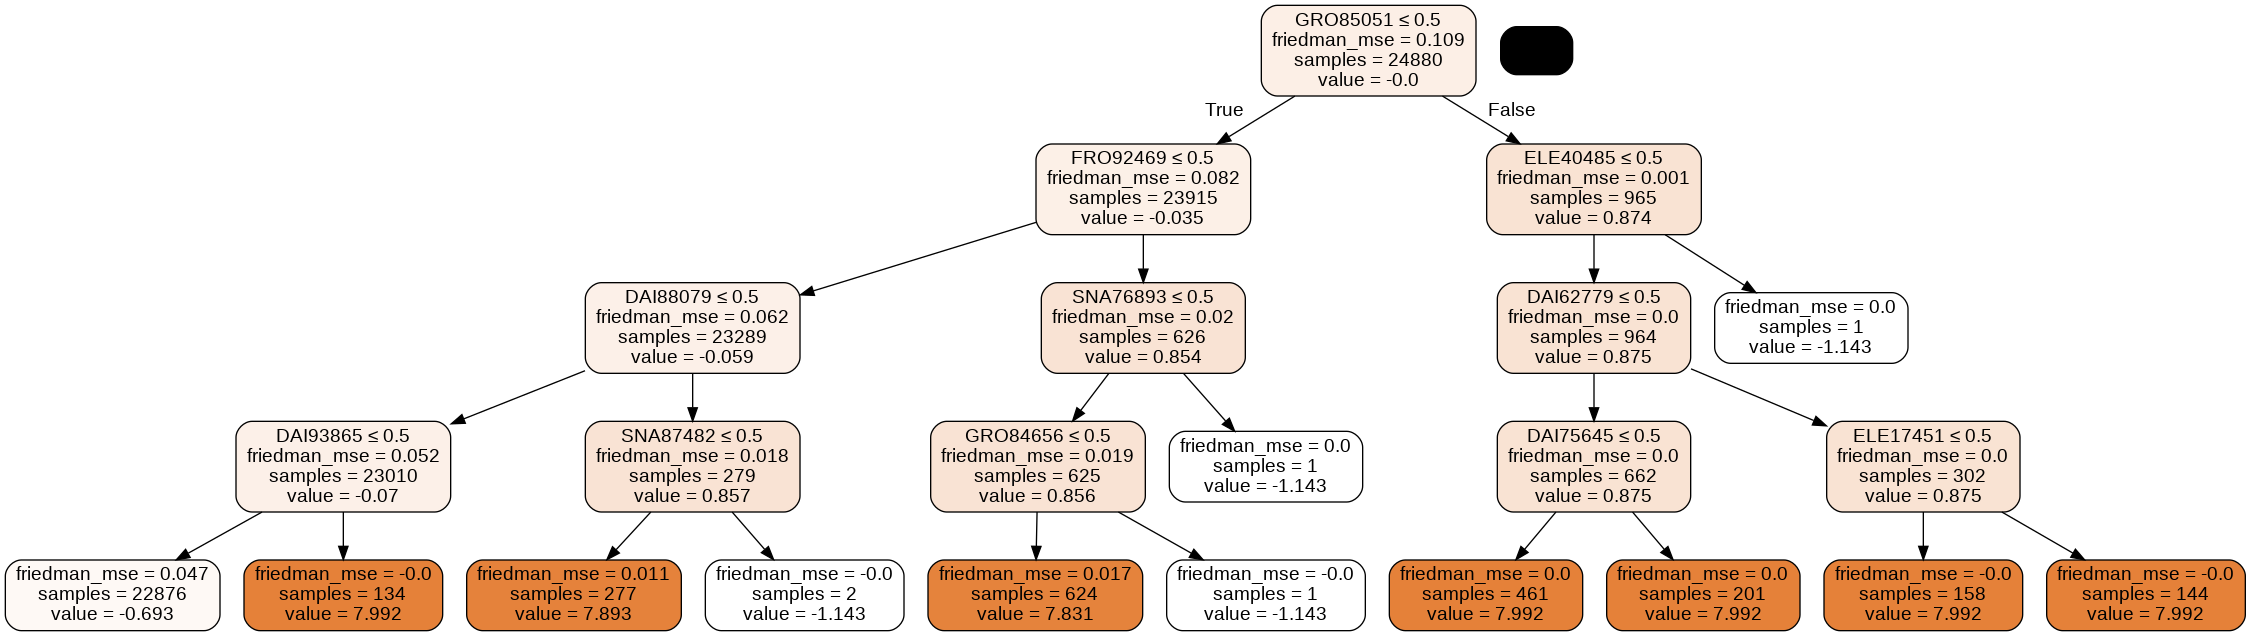

In [ ]:
from six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
ddd=mmm.estimators_[0]
dot_data = StringIO()
export_graphviz(ddd[0], out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### ***Also check out https://skope-rules.readthedocs.io/en/latest/index.html***


# Excercise

List the top 5 association rules with highest confidence scores for itemsets of size 3. The current program should be extended to do the following:

1. Create a list of candidate 3-item sets by merging two frequent item pairs. Two item pairs can generate a 3-item set if they have one element in common.
2. Read the data again so that the frequency of those candidate sets can be counted. This step should be done using the MapReduce model.
3. Remove those candidates who don't reach the support threshold $s=100$.
4. Compute the confidence value for the remaining sets, and output the top 5 itemsets.